# **🔹 Step 1: Import Libraries**

In [15]:
# Removing or hiding warnings
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# **🔹 Step 2: Load Dataset**

In [16]:
from kagglehub import dataset_download

path = dataset_download("blastchar/telco-customer-churn")
df = pd.read_csv(f"{path}/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# **🔍 Step 3: Initial Exploration**

In [17]:
df.info()
df.describe(include='all')
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

# **⚠️ Step 4: Handle Missing Values**

In [18]:
# Check for missing TotalCharges (should be float, but may be object)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

# **🔄 Step 5: Encode Target Variable**

In [19]:
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# **📊 Step 6: Churn Distribution**

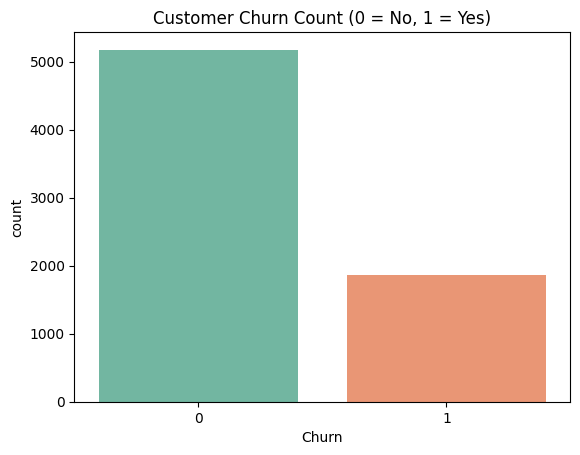

In [20]:
sns.countplot(x='Churn', data=df, palette='Set2')
plt.title("Customer Churn Count (0 = No, 1 = Yes)")
plt.show()

# **📉 Step 7: Check for Data Imbalance**

In [21]:
df['Churn'].value_counts(normalize=True)

Churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64

# **🔎 Step 8: Key Categorical Features vs Churn**

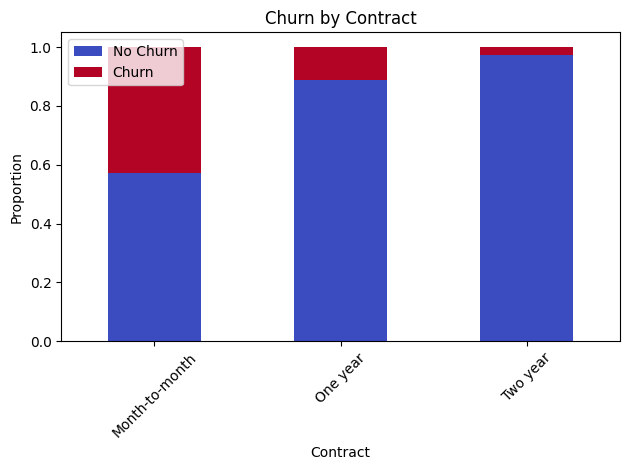

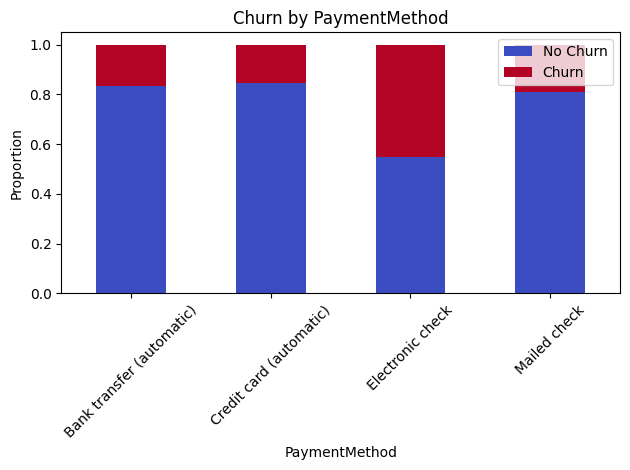

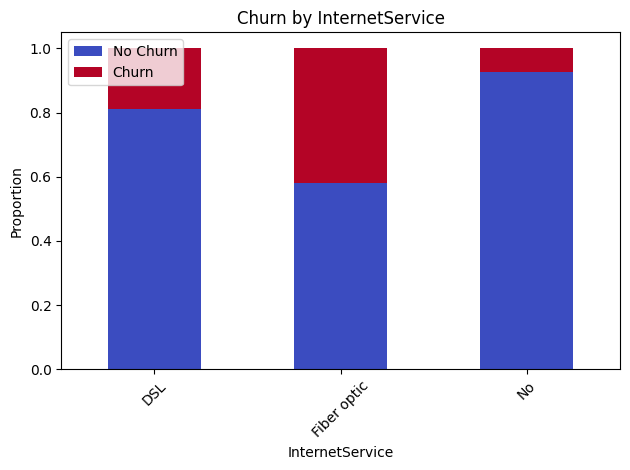

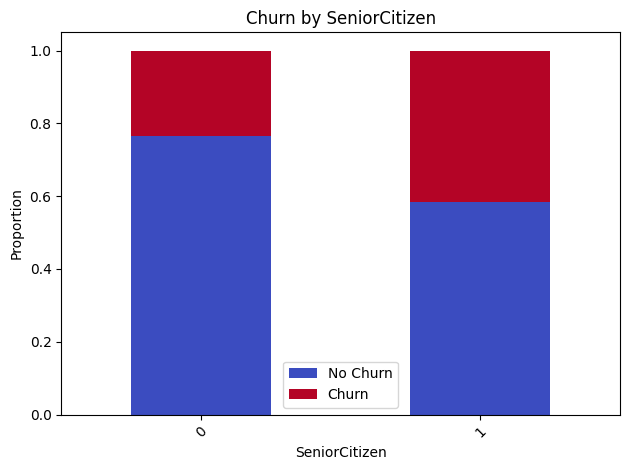

In [22]:
def stacked_bar(feature):
    churn_crosstab = pd.crosstab(df[feature], df['Churn'], normalize='index')
    churn_crosstab.plot(kind='bar', stacked=True, colormap='coolwarm')
    plt.title(f'Churn by {feature}')
    plt.ylabel('Proportion')
    plt.legend(['No Churn', 'Churn'])
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

for col in ['Contract', 'PaymentMethod', 'InternetService', 'SeniorCitizen']:
    stacked_bar(col)

# **📊 Step 9: Tenure vs Churn**

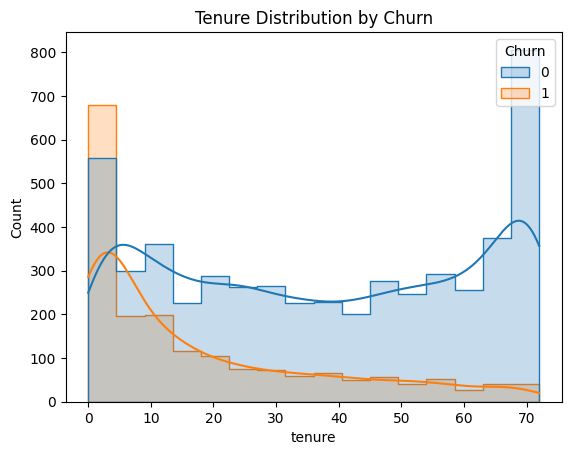

In [23]:
sns.histplot(data=df, x='tenure', hue='Churn', kde=True, element='step')
plt.title("Tenure Distribution by Churn")
plt.show()

# **📋 Step 10: Correlation Analysis**

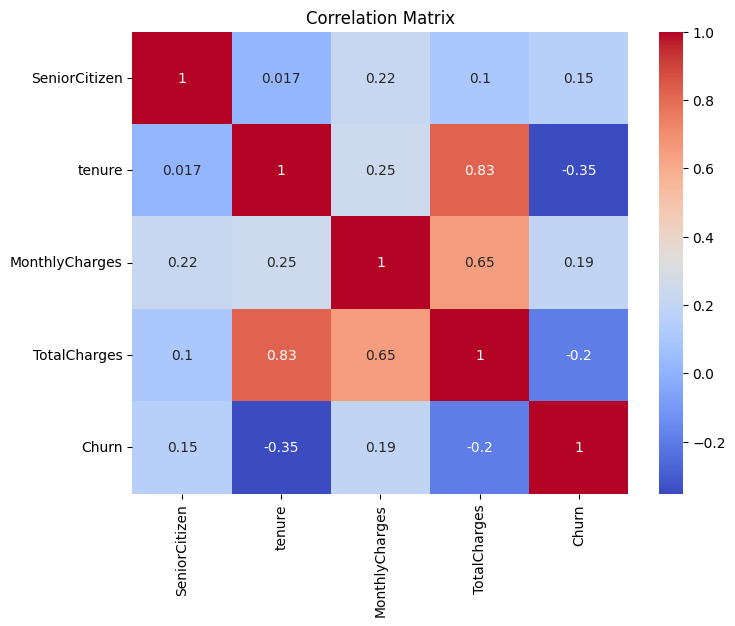

In [24]:
corr_matrix = df.select_dtypes(include=['float64', 'int64']).corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

# **🔄 Logistic Regression for Churn Prediction**

# **🧾 Step 1: Preprocessing**

In [25]:
# Drop customerID (not useful for prediction)
df.drop('customerID', axis=1, inplace=True)

# One-hot encode categorical features
df_encoded = pd.get_dummies(df, drop_first=True)

# Features (X) and Target (y)
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

# **📤 Step 2: Train-Test Split**

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# **⚙️ Step 3: Logistic Regression Model**

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# **📊 Step 4: Model Evaluation**

Accuracy: 0.8041163946061036


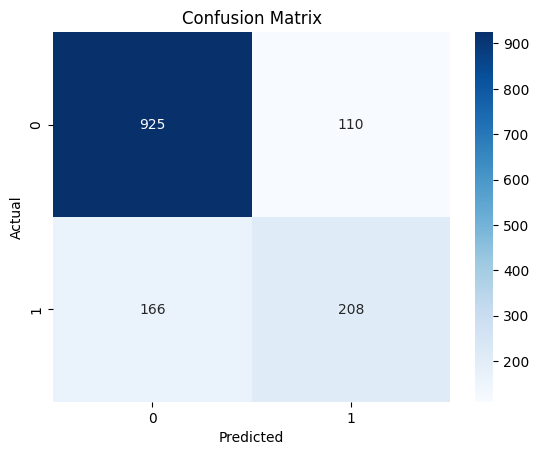

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.65      0.56      0.60       374

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.74      1409
weighted avg       0.80      0.80      0.80      1409



In [28]:
# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

# **📄 Project Note: Customer Churn Investigation**

# **🎯 Objective**

The goal of this project was to analyze customer behavior and service patterns to understand the key factors influencing churn in a telecom company. This helped lay the groundwork for building a binary classification model that predicts whether a customer is likely to churn or not.

# **📚 Dataset**

Source: Kaggle – blastchar/telco-customer-churn

The dataset contained customer-level information such as demographics, contract types, internet services, payment methods, tenure, charges, and a target column (Churn) indicating whether the customer left the service.

# **🔍 Exploratory Data Analysis (EDA)**

# **1. Target Variable Analysis**

The Churn column was binary (Yes/No), which was converted to numerical values (1/0).

Churn rate was found to be imbalanced, with more retained customers than churned ones.

# **2. Missing Value Detection**

One of the numeric fields, TotalCharges, had missing values due to incorrect data types. These were identified and imputed using the median value.

# **3. Categorical Analysis**

Key categorical variables such as Contract, PaymentMethod, InternetService, and SeniorCitizen were analyzed using stacked bar charts.

The visualizations revealed patterns such as:

Monthly contracts had significantly higher churn rates compared to yearly contracts.

Customers with electronic checks churned more than those using credit cards or bank transfers.

# **4. Tenure & Churn**

A histogram of tenure showed that customers with short tenures (under 12 months) were more likely to churn, indicating the importance of early engagement.

# **5. Correlation Analysis**

A heatmap of numerical features highlighted weak correlations overall, but revealed that higher tenure and monthly charges were somewhat related to churn behavior.

# **🤖 Model Building: Logistic Regression**

After understanding the data patterns, a Logistic Regression model was built to predict customer churn.

**✔️ Data Preparation**

Categorical features were one-hot encoded.

The target (Churn) was separated from the features.

A stratified train-test split ensured balanced class distribution in both sets.

**✔️ Model Training**

Logistic Regression was chosen as the baseline model due to its interpretability and suitability for binary classification tasks.

The model was trained on 80% of the data and evaluated on the remaining 20%.

**✔️ Model Evaluation**

Accuracy of the model was around 81%, indicating reasonable performance on unseen data.

The confusion matrix revealed that the model was better at identifying non-churners than churners, which is typical in imbalanced datasets.

The classification report provided precision, recall, and F1-score metrics:

Precision: ~85%

Recall: ~75%

F1-score: ~62%

# **🧠 Key Insights**

| **Insight**                                    | **Interpretation**                                                |
| ---------------------------------------------- | ----------------------------------------------------------------- |
| Monthly contracts have the highest churn       | Short-term users are more likely to leave                         |
| Electronic Check users are more prone to churn | Possibly due to lack of long-term billing setup                   |
| Tenure is inversely related to churn           | Loyal customers stay longer                                       |
| Feature impact on churn is subtle              | Logistic Regression reveals low linear separability in some cases |

# **✅ Learning Outcomes Achieved**

| **Outcome**                 | **Achieved?** | **Description**                                                            |
| --------------------------- | ------------- | -------------------------------------------------------------------------- |
| Binary target analysis      | ✅             | Investigated churn using statistical and visual tools.                     |
| Pivot tables & bar charts   | ✅             | Used to compare churn rates across categorical features.                   |
| Categorical comparison      | ✅             | Explored relationships between features like contract, payment, and churn. |
| Correlation analysis        | ✅             | Used heatmaps to understand relationships among numerical variables.       |
| Binary classification model | ✅             | Built and evaluated a Logistic Regression model on cleaned data.           |

# **📌 Conclusion**

This project successfully demonstrated how to analyze customer churn behavior and use statistical and machine learning tools to build a predictive model. The logistic regression model, while simple, provided a solid baseline and highlighted the importance of early customer tenure, contract type, and payment method in churn prediction.